# 학습 내용

2. 데이터 전처리
필요한 데이터를 준비하고 전처리합니다.
3. 모델 설계
Bahdanau Attention을 사용해서 코드 실습을 합니다.
4. 훈련하기
(1) Optimizer & Loss
Encoder-Decoder 구조를 정의합니다.
(2) train_step 구현하기
Loss를 계산한 후 반환하는 함수를 학습합니다.
(3) 훈련 시작하기
학습을 진행하고 시각화합니다.


# 학습 목표

데이터를 필요에 맞게 전처리할 수 있다.
Encoder-Decoder 구조를 이해할 수 있다.
Encoder-Decoder 구조를 다른 사람에게 설명할 수 있다.

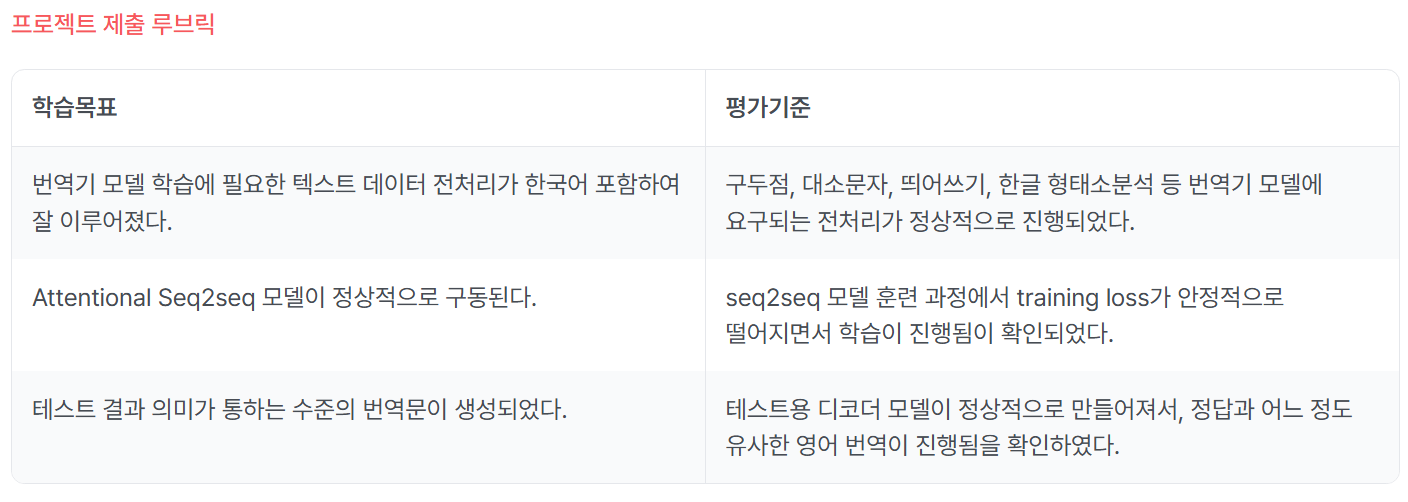

In [1]:
# 나눔고딕 설치
!mkdir -p ~/.local/share/fonts/NanumFont

!wget "http://cdn.naver.com/naver/NanumFont/fontfiles/NanumFont_TTF_ALL.zip" -O NanumFont_TTF_ALL.zip
!unzip -o NanumFont_TTF_ALL.zip -d ~/.local/share/fonts/NanumFont

# 전처리(sentence piece 설치)
!pip install sentencepiece

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install -qq fonts-nanum



--2025-11-23 08:38:14--  http://cdn.naver.com/naver/NanumFont/fontfiles/NanumFont_TTF_ALL.zip
Resolving cdn.naver.com (cdn.naver.com)... 211.47.29.200, 183.111.124.158, 125.209.207.38
Connecting to cdn.naver.com (cdn.naver.com)|211.47.29.200|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14946146 (14M) [application/zip]
Saving to: ‘NanumFont_TTF_ALL.zip’

NanumFont_TTF_ALL.z 100%[===================>]  14.25M  24.3MB/s    in 0.6s    

2025-11-23 08:38:15 (24.3 MB/s) - ‘NanumFont_TTF_ALL.zip’ saved [14946146/14946146]

Archive:  NanumFont_TTF_ALL.zip
  inflating: /home/jovyan/.local/share/fonts/NanumFont/NanumBrush.ttf  
  inflating: /home/jovyan/.local/share/fonts/NanumFont/NanumGothic.ttf  
  inflating: /home/jovyan/.local/share/fonts/NanumFont/NanumGothicBold.ttf  
  inflating: /home/jovyan/.local/share/fonts/NanumFont/NanumGothicExtraBold.ttf  
  inflating: /home/jovyan/.local/share/fonts/NanumFont/NanumMyeongjo.ttf  
  inflating: /home/jovyan/.local/share/

In [2]:
# 한글 나눔고딕 설치
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging


import seaborn as sns
import numpy as np
import os

font_path = '/home/jovyan/.local/share/fonts/NanumFont/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

# 데이터 전처리
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

# EDA
import numpy as np
import matplotlib.pyplot as plt

# plot
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import os




2.7.1+cu118


# 
데이터 전처리

데이터를 다운로드하는 데에는 urllib.request.urlretrieve() 함수를 사용할 겁니다. urllib.request.urlretrieve()함수는 URL로부터 데이터를 다운받고, zip_ref.extractall() 함수는 폴더 내 압축된 파일들을 찾아 해제까지 알아서 할 수 있는 똑똑한 함수랍니다! 

# 한국어-영어 데이터 링크주소
https://www.manythings.org/anki/

In [3]:
# 데이터 다운로드
USE_FILE = True
DATA_PATH = "/home/jovyan/work/kor-eng/kor.txt"

df = pd.read_table(
    DATA_PATH,
    header=None,           # 헤더 줄이 없다고 명시
    names=["eng", "kor","etc"]   # 첫 번째 열=eng, 두 번째 열=kor
).drop(columns=["etc"])

print(df.head)
print(df.shape)

<bound method NDFrame.head of                                                     eng  \
0                                                   Go.   
1                                                   Hi.   
2                                                  Run!   
3                                                  Run.   
4                                                  Who?   
...                                                 ...   
6376  I started a new blog. I'll do my best not to b...   
6377  I think it's a shame that some foreign languag...   
6378  And the good news is that today the economy is...   
6379  If someone who doesn't know your background sa...   
6380  Doubtless there exists in this world precisely...   

                                                    kor  
0                                                    가.  
1                                                   안녕.  
2                                                   뛰어!  
3                            

영어 단어수 (토큰화 전)
최소 단어수: 1
최대 단어수: 101
평균 단어수: 5.49

한국어 단어수 (토큰화 전)
최소 단어수: 1
최대 단어수: 89
평균 단어수: 4.21


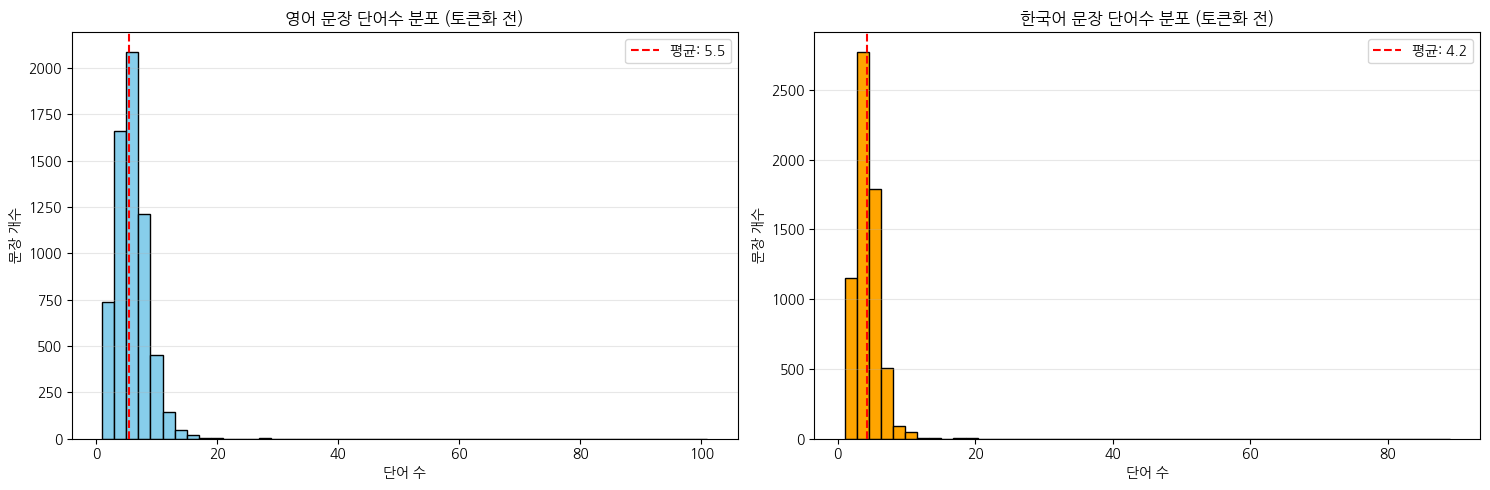


백분위수 통계
상위 90% 단어수 -> 영어: 9 | 한국어: 7
상위 95% 단어수 -> 영어: 10 | 한국어: 7
상위 99% 단어수 -> 영어: 13 | 한국어: 10
상위 99.9% 단어수 -> 영어: 20 | 한국어: 16


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# === 영어 단어수 분포 ===
eng_texts = df["eng"].astype(str)
eng_lengths = [len(sen.split()) for sen in eng_texts]

print("=" * 50)
print("영어 단어수 (토큰화 전)")
print("=" * 50)
print(f"최소 단어수: {min(eng_lengths)}")
print(f"최대 단어수: {max(eng_lengths)}")
print(f"평균 단어수: {np.mean(eng_lengths):.2f}")

axes[0].hist(eng_lengths, bins=50, edgecolor='black', color='skyblue')
axes[0].axvline(np.mean(eng_lengths), color='red', linestyle='--', 
                label=f'평균: {np.mean(eng_lengths):.1f}')
axes[0].set_xlabel("단어 수")
axes[0].set_ylabel("문장 개수")
axes[0].set_title("영어 문장 단어수 분포 (토큰화 전)")
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# === 한국어 단어수 분포 ===
kor_texts = df["kor"].astype(str)
kor_lengths = [len(sen.split()) for sen in kor_texts]

print("\n" + "=" * 50)
print("한국어 단어수 (토큰화 전)")
print("=" * 50)
print(f"최소 단어수: {min(kor_lengths)}")
print(f"최대 단어수: {max(kor_lengths)}")
print(f"평균 단어수: {np.mean(kor_lengths):.2f}")

axes[1].hist(kor_lengths, bins=50, edgecolor='black', color='orange')
axes[1].axvline(np.mean(kor_lengths), color='red', linestyle='--', 
                label=f'평균: {np.mean(kor_lengths):.1f}')
axes[1].set_xlabel("단어 수")
axes[1].set_ylabel("문장 개수")
axes[1].set_title("한국어 문장 단어수 분포 (토큰화 전)")
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 백분위수 추가
print("\n" + "=" * 50)
print("백분위수 통계")
print("=" * 50)
for p in [90, 95, 99, 99.9]:
    eng_p = int(np.percentile(eng_lengths, p))
    kor_p = int(np.percentile(kor_lengths, p))
    print(f"상위 {p}% 단어수 -> 영어: {eng_p} | 한국어: {kor_p}")

In [5]:
# 정제
# 전처리 함수 정의
def preprocess_sentence(text):
    """
    텍스트 전처리 함수
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # 1. 소문자화
    text = text.lower()

    # 2. 반복되는 문장 부호 제거 (2개 이상 → 1개)
    text = re.sub(r'([.!?,])\1+', r'\1', text)

    # 3. 영어/숫자/한글/문장부호만 남기고 모두 삭제
    # 이모지, 이모티콘, 특수문자 자동 제거
    # ' -> 추가
    text = re.sub(r"[^가-힣a-zA-Z0-9\s.!?,']", " ", text)

    # 4. 문장부호 앞뒤로 공백 추가
    text = re.sub(r'([.!?,])', r' \1 ', text)

    # 5. 연속 공백을 하나의 공백으로 교체
    text = re.sub(r'\s+', ' ', text)

    # 6. 앞뒤 공백 제거
    text = text.strip()

    return text

전처리 과정에서 문장의 시작 문자 <start>, 종료 문자 <end> 를 붙여주게 됩니다. 이 작업은 Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않지만, Decoder의 입력 문장과 라벨로 사용할 출력 문장에는 꼭 필요하게 됩니다. 이전 렉처 노드에서 살펴보았듯, Decoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요하기 때문입니다.

In [6]:
#df = df[:30000]

df["eng"] = df["eng"].apply(preprocess_sentence)
df["kor"] = df["kor"].apply(lambda x: preprocess_sentence(x))

df.tail()

,eng,kor
6376,i started a new blog . i'll do my best not to ...,난 블로그를 시작했어 . 블로그를 초반에만 반짝 많이 하다가 관두는 사람처럼은 되지...
6377,i think it's a shame that some foreign languag...,몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었...
6378,and the good news is that today the economy is...,"다음으로 좋은 소식은 오늘 경제가 재성장한다는 것입니다 . 임금 , 소득 , 집값 ..."
6379,if someone who doesn't know your background sa...,만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어...
6380,doubtless there exists in this world precisely...,의심의 여지 없이 세상에는 어떤 남자이든 정확히 딱 알맞는 여자와 결혼하거나 그 반...


SentencePiece를 사용하려면 텍스트 파일이 필요합니다. 먼저 SentencePiece를 활용해 Tokenizer를 생성하고 테이터를 변환하겠습니다. 변환된 텐서를 80%의 훈련 데이터와 20%의 검증 데이터로 분리하세요! (Tokenizer의 단어 수는 자유롭게 진행하세요!)

In [7]:
# 토큰화

df["eng"].to_csv("eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
df["kor"].to_csv("kor_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, kor_corpus.txt")


파일 저장 완료: eng_corpus.txt, kor_corpus.txt


In [8]:
# 1. 단 기준 95% coverage vocab size
from collections import Counter

def vocab_size_for_coverage_word(texts, coverage=0.95):
    """
    texts: 문장 리스트
    coverage: 목표 커버리지 (기본 0.95)
    """
    counter = Counter()
    for sent in texts:
        # 아주 간단히 공백 기준 토큰화 (필요하면 전처리/토크나이저 교체)
        tokens = str(sent).split()
        counter.update(tokens)

    total_count = sum(counter.values())
    freq_list = sorted(counter.items(), key=lambda x: x[1], reverse=True)

    cum = 0
    vocab_size = 0
    for i, (tok, freq) in enumerate(freq_list, start=1):
        cum += freq
        if cum / total_count >= coverage:
            vocab_size = i
            break

    return vocab_size

# 예시: 영어 문장 기준
texts_eng = df["eng"].astype(str).tolist()
vocab_95_word = vocab_size_for_coverage_word(texts_eng, coverage=0.95)
print("단어 기준 95% coverage vocab size:", vocab_95_word)


단어 기준 95% coverage vocab size: 1591


In [76]:
vocab_size = 2300
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

spm.SentencePieceTrainer.train(
    input = "eng_corpus.txt",
    model_prefix = "encoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

spm.SentencePieceTrainer.train(
    input = "kor_corpus.txt",
    model_prefix = "decoder_spm",
    vocab_size = vocab_size,
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: eng_corpus.txt
  input_format: 
  model_prefix: encoder_spm
  model_type: UNIGRAM
  vocab_size: 2300
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  d

In [77]:
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model")

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model")

True

In [78]:
df

,eng,kor
0,go .,가 .
1,hi .,안녕 .
2,run !,뛰어 !
3,run .,뛰어 .
4,who ?,누구 ?
...,...,...
6376,i started a new blog . i'll do my best not to ...,난 블로그를 시작했어 . 블로그를 초반에만 반짝 많이 하다가 관두는 사람처럼은 되지...
6377,i think it's a shame that some foreign languag...,몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었...
6378,and the good news is that today the economy is...,"다음으로 좋은 소식은 오늘 경제가 재성장한다는 것입니다 . 임금 , 소득 , 집값 ..."
6379,if someone who doesn't know your background sa...,만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어...


In [79]:
eng_sample = df["eng"][1000]
kor_sample = df["kor"][1000]
print(eng_sample)
print(kor_sample)

he will also go .
그도 갈 것이다 .


문장을 인코딩한 뒤 START_TOKEN과 END_TOKEN을 붙여주겠습니다.

In [80]:
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
enc_token

[1, 28, 98, 115, 1532, 39, 4, 2]

In [81]:
enc_decoding = encoder_tokenizer.decode(enc_token)
enc_decoding

'he will also go .'

이처럼 디코딩 과정에선 START_TOKEN과 END_TOKEN 부분을 제외하고 디코딩을 합니다.

START_TOKEN과 END_TOKEN은 데이터셋을 생성하는 과정에서 추가해주도록 하겠습니다. 일반적으로 Padding 작업은 torch.nn.utils.rnn.pad_sequence와 같은 라이브러리를 사용하지만 여기에서는 과정을 좀 더 풀어서 보여드리도록 하겠습니다.

영어 최대 길이: 166
한국어 최대 길이: 171
영어 평균 길이: 9.19
한국어 평균 길이: 9.45
상위 90% 길이 -> 영어: 14 | 한국어: 14
상위 95% 길이 -> 영어: 16 | 한국어: 16
상위 99% 길이 -> 영어: 21 | 한국어: 21
상위 99.9% 길이 -> 영어: 32 | 한국어: 36


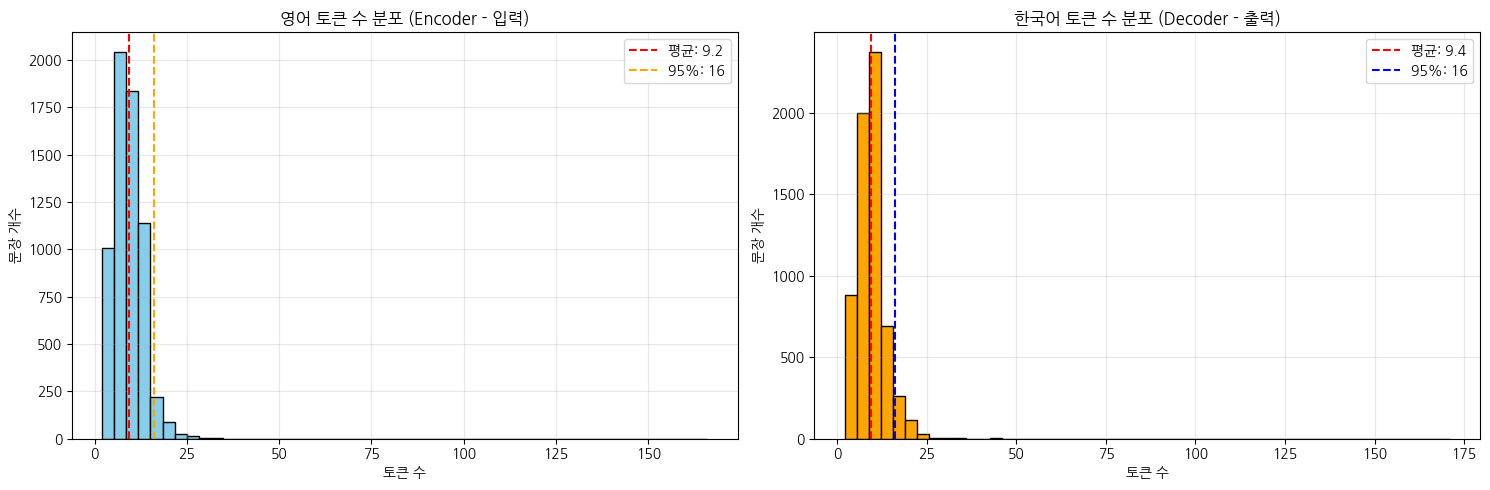

In [82]:
# 1) 영어 문장 토큰 길이 계산
eng_lengths = []
for sen in df["eng"].astype(str):
    tokens = encoder_tokenizer.encode(sen, out_type=str)
    eng_lengths.append(len(tokens))

# 2) 한국어 문장 토큰 길이 계산
kor_lengths = []
for sen in df["kor"].astype(str):
    tokens = decoder_tokenizer.encode(sen, out_type=str)
    kor_lengths.append(len(tokens))

# 3) 통계 출력
print("영어 최대 길이:", max(eng_lengths))
print("한국어 최대 길이:", max(kor_lengths))
print(f"영어 평균 길이: {np.mean(eng_lengths):.2f}")
print(f"한국어 평균 길이: {np.mean(kor_lengths):.2f}")

# 백분위수 계산
percentiles = [90, 95, 99, 99.9]
for p in percentiles:
    eng_p = int(np.percentile(eng_lengths, p))
    kor_p = int(np.percentile(kor_lengths, p))
    print(f"상위 {p}% 길이 -> 영어: {eng_p} | 한국어: {kor_p}")

# 4) 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 영어 (Encoder)
axes[0].hist(eng_lengths, bins=50, edgecolor='black', color='skyblue')
axes[0].axvline(np.mean(eng_lengths), color='red', linestyle='--', 
                label=f'평균: {np.mean(eng_lengths):.1f}')
axes[0].axvline(np.percentile(eng_lengths, 95), color='orange', linestyle='--', 
                label=f'95%: {np.percentile(eng_lengths, 95):.0f}')
axes[0].set_xlabel("토큰 수")
axes[0].set_ylabel("문장 개수")
axes[0].set_title("영어 토큰 수 분포 (Encoder - 입력)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 한국어 (Decoder)
axes[1].hist(kor_lengths, bins=50, edgecolor='black', color='orange')
axes[1].axvline(np.mean(kor_lengths), color='red', linestyle='--', 
                label=f'평균: {np.mean(kor_lengths):.1f}')
axes[1].axvline(np.percentile(kor_lengths, 95), color='blue', linestyle='--', 
                label=f'95%: {np.percentile(kor_lengths, 95):.0f}')
axes[1].set_xlabel("토큰 수")
axes[1].set_ylabel("문장 개수")
axes[1].set_title("한국어 토큰 수 분포 (Decoder - 출력)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [83]:
# padding
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx]['eng']
        trg_text = self.data.iloc[idx]['kor']

        src_ids = self.encoder_tokenizer.encode(src_text)
        trg_ids = self.decoder_tokenizer.encode(trg_text)

        src_ids = src_ids[:self.max_len]

        # Decoder의 입력에는 START_TOKEN과 END_TOKEN을 추가해줍니다. 단, 최대 길이 제한을 적용시킵니다.
        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]

        # 길이가 짧은 경우 PAD_TOKEN을 추가해줍니다.
        src_ids = src_ids + [self.pad_id] * (self.max_len - len(src_ids))
        trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))

        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

In [84]:
train_ratio = 0.8  # 전체 길이의 80%
MAX_LEN = 40 # 임의의 값
BATCH_SIZE = 64

train_data = df.sample(frac=train_ratio, random_state=42)  # 70% 훈련 데이터
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validataion_data, batch_size=BATCH_SIZE, shuffle=False)

In [85]:
for src, trg_input, trg_label in train_loader:
    print(src.shape, trg_input.shape, trg_label.shape)
    break

torch.Size([64, 40]) torch.Size([64, 40]) torch.Size([64, 40])


# 모델 설계

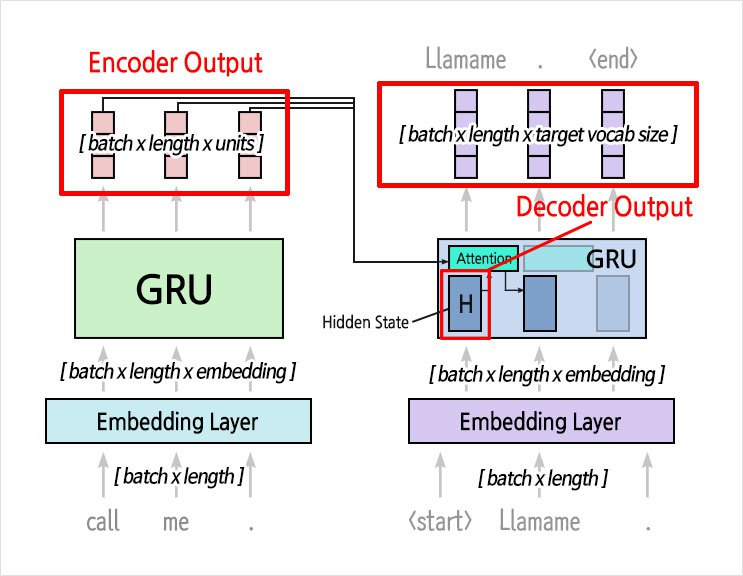

Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖고, Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 t Step의 Hidden State를 만들어 냅니다.

Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달됩니다.

여기서 't=1 일 때의 Hidden State는 어떻게 정의할 것인가?' 가 궁금하실 수 있는데요, 일반적으로 Encoder의 Final State를 Hidden State로 사용합니다.

## Attention은 Bahdanau을 사용
Bahdanau Attention은 입력 시퀀스의 각 위치마다 가중치를 학습하여 중요도를 결정한다.
즉 입력 시퀀스의 다른 위치에 대한 주의도가 다를수 있다. 이를 통해 모델이 입력 시퀀스의 특정 부분에 집중하거나 무시할 수 있다.


In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # W1: Encoder outputs (H_j)를 변환. 양방향이므로 hidden_dim * 2
        self.W1 = nn.Linear(hidden_dim * 2, hidden_dim)
        # W2: Decoder hidden state (s_{i-1})를 변환
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        # v: Energy(e_ij)를 계산하기 위한 벡터
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask =None):
        # hidden: (batch_size, hidden_dim) -> 디코더의 이전 은닉 상태 s_{t-1}
        # encoder_outputs: (src_len, batch_size, hidden_dim * 2) -> 인코더의 전체 출력 H

        src_len = encoder_outputs.shape[0]

        # Score(Alignment Model) 계산: e_{ij} = v_a^T tanh(W_a s_{i-1} + U_a h_j)
        # 차원 맞추기: (batch, src_len, hidden)
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Tanh 안의 덧셈 연산 (Broadcasting)
        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        
        # 스칼라 값인 score 계산
        attention = self.v(energy).squeeze(2) # (batch_size, src_len)

        # ★★★ 여기서 Masking 적용 ★★★
        if mask is not None:
            # mask가 0인 부분(pad)의 energy를 매우 작은 값(-1e10)으로 채움
            # 이렇게 하면 Softmax를 거쳤을 때 0에 수렴함
            attention = attention.masked_fill(mask == 0, -1e10)

        # Softmax를 통해 확률 분포(alpha_{ij}) 생성
        return F.softmax(attention, dim=1)


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout_ratio=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        
        # Bahdanau 논문은 Bidirectional RNN 사용
        self.rnn = nn.GRU(emb_dim, hidden_dim, bidirectional=True)
        
        # 양방향 마지막 hidden state를 하나로 합쳐 디코더의 초기 hidden state로 사용
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        # src: (src_len, batch_size)
        embedded = self.dropout(self.embedding(src))
        
        # outputs: (src_len, batch_size, hidden_dim * 2) -> 모든 시점의 h_j (annotation)
        # hidden: (2, batch_size, hidden_dim) -> 마지막 시점의 hidden state
        outputs, hidden = self.rnn(embedded)
        
        # 정방향(forward)과 역방향(backward)의 마지막 상태를 결합하여 디코더 초기 상태 생성
        # hidden[-2]: Forward last, hidden[-1]: Backward last
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        # 디코더가 기대하는 차원 (1, batch, hidden)으로 변환
        return outputs, hidden.unsqueeze(0)


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention, dropout_ratio=0.5):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        
        # ★ 핵심 수정 1: GRU 입력 차원 변경 ★
        # GRU input = Embedding(y_{t-1}) + Context Vector(c_t)
        # Context Vector 차원 = Encoder hidden * 2 (Bidirectional)
        self.rnn = nn.GRU(emb_dim + hidden_dim * 2, hidden_dim)
        
        # Deep Output Layer (Prediction)
        # Input = RNN output(s_t) + Context(c_t) + Embedding(y_{t-1})
        self.fc_out = nn.Linear(emb_dim + hidden_dim * 3, output_dim)

    def forward(self, input, hidden, encoder_outputs, mask=None): # mask인자 추
        # input: (batch_size) -> 단어 인덱스 y_{t-1}
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input)) # (1, batch, emb_dim)

        # 1. Attention Weights 계산 (alpha, mask 전달)
        # hidden은 s_{t-1}
        a = self.attention(hidden[-1], encoder_outputs, mask)
        a = a.unsqueeze(1) # (batch, 1, src_len)

        # 2. Context Vector 계산 (c_t)
        # c_t = sum(alpha * h_j)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch, src_len, hidden*2)
        context = torch.bmm(a, encoder_outputs) # (batch, 1, hidden*2)
        context = context.permute(1, 0, 2) # (1, batch, hidden*2)

        # ★ 핵심 수정 2: Context Vector를 RNN 입력에 포함 ★
        # s_t = f(s_{t-1}, y_{t-1}, c_t)
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # RNN 업데이트
        output, hidden = self.rnn(rnn_input, hidden)
        
        # 3. 최종 예측 (Deep Output)
        # p(y_t | ...) ~ g(y_{t-1}, s_t, c_t)
        # 필요한 모든 정보를 결합하여 다음 단어 예측
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        context = context.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))
        
        return prediction, hidden, a.squeeze(1)


class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder,pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx # Padding Index 저장
        self.device = device

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5, max_len=40, bos_id=1, eos_id=2):
        batch_size = src.shape[1]
        outputs = []
        attentions = []

        # ★ Mask 생성 (Seq2SeqAttention에서 수행) ★
        # src: (src_len, batch_size) -> permute -> (batch_size, src_len)
        # pad_idx가 아닌 부분은 1, pad_idx인 부분은 0
        mask = (src != self.pad_idx).permute(1, 0)

        # Encoder 구동
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            # 학습 모드 (Teacher Forcing 사용 가능)
            trg_len = trg.shape[0]
            input = trg[0, :] # <sos> token
            
            for t in range(1, trg_len):
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs, mask)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                
                teacher_force = random.random() < teacher_forcing_ratio
                top1 = output.argmax(1)
                # Teacher Forcing: 정답을 다음 입력으로 사용 vs 모델 예측을 다음 입력으로 사용
                input = trg[t] if teacher_force else top1
        else:
            # 추론 모드 (Inference)
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)
            
            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                
                top1 = output.argmax(1)
                input = top1
                
                # EOS 토큰을 만나면 종료 처리
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)
        attentions = torch.cat(attentions, dim=0)

        return outputs, attentions

In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = len(encoder_tokenizer)
output_dim = len(decoder_tokenizer)
emb_dim = 256
hid_dim = 512
pad_idx = 0

In [114]:
encoder = Encoder(input_dim, emb_dim, hid_dim).to(device)
attention = BahdanauAttention(hid_dim).to(device)
decoder = Decoder(output_dim, emb_dim, hid_dim, attention).to(device)
model = Seq2SeqAttention(encoder, decoder, pad_idx, device).to(device)

print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(2300, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=1024, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(2300, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=2300, bias=True)
  )
)


코드를 실행하면 다음과 같은 형식의 결과가 나와야 합니다.
------------------------------------------------------
Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(3000, 256)
    (rnn): LSTM(256, 512)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=512, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3000, 256)
    (rnn): LSTM(256, 512)
    (fc_out): Linear(in_features=1024, out_features=3000, bias=True)
  )
)

# 훈련하기

In [115]:
# (1) Optimizer & Loss

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

print("슝~")

슝~


In [116]:
# (2) train_step 구현하기

def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=True)

    for src, trg_input, trg_label in progress_bar:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)
        
        # [중요] (Batch_Size, Seq_Len) -> (Seq_Len, Batch_Size)로 변환
        src = src.transpose(0, 1)
        trg_input = trg_input.transpose(0, 1)
        # trg_label은 Loss 계산시 flatten 할 것이므로 여기서 변환 안 해도 되지만, 
        # 일관성을 위해 변환하거나, 아래 Loss 계산 로직을 맞춰야 합니다.
        trg_label = trg_label.transpose(0, 1) 
        
        optimizer.zero_grad()
        
        # trg_input이 (Seq_Len, Batch_Size)가 되었으므로
        # Seq2Seq 모델 내부의 반복문이 정상적으로 Time Step만큼 돕니다.
        outputs, _ = model(src, trg_input)
        
        # ★ 중요 수정: Shape Mismatch 해결 ★
        # trg_label에서 <sos> 토큰(첫 번째 시점) 제거
        # outputs는 trg[1:]에 대한 예측이므로 label도 trg[1:]이어야 함
        trg_label = trg_label[1:]
        
        
        # Loss 계산을 위한 Shape 변환
        # outputs: (trg_len, batch_size, output_dim) -> (trg_len * batch_size, output_dim)
        outputs = outputs.view(-1, outputs.shape[-1])
        # trg_label: (trg_len, batch_size) -> (trg_len * batch_size)
        trg_label = trg_label.reshape(-1)
        
        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(data_loader)

print("슝~")


슝~


코드를 좀 더 자세히 살펴봅시다.

train_step()의 학습 과정은 아래와 같습니다.

model.train()을 호출하여 모델을 학습 모드로 전환합니다.
optimizer.zero_grad()를 통해 이전 배치에서 계산된 기울기를 초기화합니다.
Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_hidden Encoder 처리
<start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. predictions
예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 사용X)
반복!

In [117]:
# (3) 훈련 시작하기

# 먼저 EPOCHS = 10 만큼 반복하는 루프에 진입한 후, 각 배치의 시작 인덱스를 idx_list 배열에 저장합니다. 그리고 모델이 학습을 원활하게 할 수 있도록 데이터를 섞어줘야 하는데요, 인덱스를 섞어서 처리할 겁니다. 순차적인 인덱스로 데이터를 불러오는 게 아닌 랜덤한 인덱스로 데이터를 불러오는 것은 데이터를 섞는 것과 동일한 효과를 가져오겠죠!

# 그 후에 각 미니배치를 train_step() 함수에서 학습합니다. train_step()은 학습에 필요한 것은 모두 가져가 Loss를 계산한 후 반환하는 함수였죠!

In [128]:
%%time

EPOCHS = 50

for epoch in range(EPOCHS):

    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}')


# tqdm은 훈련의 진행 과정을 한눈에 볼 수 있게 해주는 라이브러리

Epoch 1: 100%|██████████| 80/80 [00:21<00:00,  3.65it/s, loss=1.47]


Epoch 1/50, Train Loss: 1.3175


Epoch 2: 100%|██████████| 80/80 [00:18<00:00,  4.28it/s, loss=1.41]


Epoch 2/50, Train Loss: 1.2994


Epoch 3: 100%|██████████| 80/80 [00:18<00:00,  4.41it/s, loss=1.31]


Epoch 3/50, Train Loss: 1.2552


Epoch 4: 100%|██████████| 80/80 [00:18<00:00,  4.40it/s, loss=1.23] 


Epoch 4/50, Train Loss: 1.2093


Epoch 5: 100%|██████████| 80/80 [00:18<00:00,  4.31it/s, loss=1.2]  


Epoch 5/50, Train Loss: 1.2048


Epoch 6: 100%|██████████| 80/80 [00:18<00:00,  4.28it/s, loss=1.17] 


Epoch 6/50, Train Loss: 1.1507


Epoch 7: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=1.18] 


Epoch 7/50, Train Loss: 1.1282


Epoch 8: 100%|██████████| 80/80 [00:18<00:00,  4.38it/s, loss=1.1]  


Epoch 8/50, Train Loss: 1.0878


Epoch 9: 100%|██████████| 80/80 [00:18<00:00,  4.36it/s, loss=1.49] 


Epoch 9/50, Train Loss: 1.1072


Epoch 10: 100%|██████████| 80/80 [00:18<00:00,  4.32it/s, loss=0.926]


Epoch 10/50, Train Loss: 1.0532


Epoch 11: 100%|██████████| 80/80 [00:18<00:00,  4.32it/s, loss=0.831]


Epoch 11/50, Train Loss: 1.0470


Epoch 12: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=1.22] 


Epoch 12/50, Train Loss: 1.0303


Epoch 13: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=1.22] 


Epoch 13/50, Train Loss: 0.9891


Epoch 14: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=1.06] 


Epoch 14/50, Train Loss: 0.9876


Epoch 15: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=1.37] 


Epoch 15/50, Train Loss: 0.9631


Epoch 16: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.932]


Epoch 16/50, Train Loss: 0.9399


Epoch 17: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=1.16] 


Epoch 17/50, Train Loss: 0.9463


Epoch 18: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.835]


Epoch 18/50, Train Loss: 0.9153


Epoch 19: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.861]


Epoch 19/50, Train Loss: 0.9009


Epoch 20: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.99] 


Epoch 20/50, Train Loss: 0.8859


Epoch 21: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.918]


Epoch 21/50, Train Loss: 0.8728


Epoch 22: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.825]


Epoch 22/50, Train Loss: 0.8559


Epoch 23: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.873]


Epoch 23/50, Train Loss: 0.8339


Epoch 24: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.758]


Epoch 24/50, Train Loss: 0.8186


Epoch 25: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.905]


Epoch 25/50, Train Loss: 0.8326


Epoch 26: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.681]


Epoch 26/50, Train Loss: 0.8173


Epoch 27: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.778]


Epoch 27/50, Train Loss: 0.8084


Epoch 28: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.759]


Epoch 28/50, Train Loss: 0.8053


Epoch 29: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.951]


Epoch 29/50, Train Loss: 0.7804


Epoch 30: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.891]


Epoch 30/50, Train Loss: 0.7690


Epoch 31: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.681]


Epoch 31/50, Train Loss: 0.7532


Epoch 32: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=1.04] 


Epoch 32/50, Train Loss: 0.7695


Epoch 33: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.726]


Epoch 33/50, Train Loss: 0.7513


Epoch 34: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.789]


Epoch 34/50, Train Loss: 0.7353


Epoch 35: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.72] 


Epoch 35/50, Train Loss: 0.7276


Epoch 36: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.866]


Epoch 36/50, Train Loss: 0.7186


Epoch 37: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.681]


Epoch 37/50, Train Loss: 0.7137


Epoch 38: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.708]


Epoch 38/50, Train Loss: 0.7181


Epoch 39: 100%|██████████| 80/80 [00:18<00:00,  4.32it/s, loss=0.971]


Epoch 39/50, Train Loss: 0.7231


Epoch 40: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.511]


Epoch 40/50, Train Loss: 0.6972


Epoch 41: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.625]


Epoch 41/50, Train Loss: 0.6966


Epoch 42: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.644]


Epoch 42/50, Train Loss: 0.6890


Epoch 43: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.65] 


Epoch 43/50, Train Loss: 0.6934


Epoch 44: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.576]


Epoch 44/50, Train Loss: 0.6807


Epoch 45: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.792]


Epoch 45/50, Train Loss: 0.6710


Epoch 46: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.764]


Epoch 46/50, Train Loss: 0.6586


Epoch 47: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.808]


Epoch 47/50, Train Loss: 0.6699


Epoch 48: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.535]


Epoch 48/50, Train Loss: 0.6569


Epoch 49: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.647]


Epoch 49/50, Train Loss: 0.6574


Epoch 50: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.637]

Epoch 50/50, Train Loss: 0.6368
CPU times: user 14min 4s, sys: 1min 25s, total: 15min 30s
Wall time: 15min 25s


In [129]:
# Step 1에서 분리한 Validation Set을 사용하는 eval_step() 함수를 정의
def eval_step(model, data_loader, optimizer, criterion):
    model.eval()
    total_loss = 0

    for src, trg_input, trg_label in data_loader:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)

        # [중요] (Batch_Size, Seq_Len) -> (Seq_Len, Batch_Size)로 변환
        src = src.transpose(0, 1)
        trg_input = trg_input.transpose(0, 1)
        # trg_label은 Loss 계산시 flatten 할 것이므로 여기서 변환 안 해도 되지만, 
        # 일관성을 위해 변환하거나, 아래 Loss 계산 로직을 맞춰야 합니다.
        trg_label = trg_label.transpose(0, 1) 
        
        optimizer.zero_grad()

        # ★ 중요 수정: Shape Mismatch 해결 ★
        # trg_label에서 <sos> 토큰(첫 번째 시점) 제거
        # outputs는 trg[1:]에 대한 예측이므로 label도 trg[1:]이어야 함
        trg_label = trg_label[1:]
        
        # trg_input이 (Seq_Len, Batch_Size)가 되었으므로
        # Seq2Seq 모델 내부의 반복문이 정상적으로 Time Step만큼 돕니다.
        outputs, _ = model(src, trg_input)
        
        # Loss 계산을 위한 Shape 변환
        # outputs: (trg_len, batch_size, output_dim) -> (trg_len * batch_size, output_dim)
        outputs = outputs.view(-1, outputs.shape[-1])
        # trg_label: (trg_len, batch_size) -> (trg_len * batch_size)
        trg_label = trg_label.reshape(-1)

        loss = criterion(outputs, trg_label)
        total_loss += loss.item()

    return total_loss / len(data_loader)

print("슝~")

슝~


In [130]:
%%time

EPOCHS = 50

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion, epoch)
    valid_loss = eval_step(model, validation_loader, optimizer, criterion)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

Epoch 1: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.659]


Epoch 1/50, Train Loss: 0.6290, Validation Loss: 6.7549


Epoch 2: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.679]


Epoch 2/50, Train Loss: 0.6318, Validation Loss: 6.7312


Epoch 3: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.579]


Epoch 3/50, Train Loss: 0.6332, Validation Loss: 6.7470


Epoch 4: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.897]


Epoch 4/50, Train Loss: 0.6327, Validation Loss: 6.7817


Epoch 5: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.756]


Epoch 5/50, Train Loss: 0.6148, Validation Loss: 6.8548


Epoch 6: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.652]


Epoch 6/50, Train Loss: 0.6086, Validation Loss: 6.8350


Epoch 7: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.663]


Epoch 7/50, Train Loss: 0.6143, Validation Loss: 6.8142


Epoch 8: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.616]


Epoch 8/50, Train Loss: 0.6100, Validation Loss: 6.8386


Epoch 9: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.664]


Epoch 9/50, Train Loss: 0.6081, Validation Loss: 6.9814


Epoch 10: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.711]


Epoch 10/50, Train Loss: 0.5986, Validation Loss: 6.8658


Epoch 11: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.637]


Epoch 11/50, Train Loss: 0.5964, Validation Loss: 7.0450


Epoch 12: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.595]


Epoch 12/50, Train Loss: 0.5960, Validation Loss: 6.9840


Epoch 13: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.459]


Epoch 13/50, Train Loss: 0.5730, Validation Loss: 7.0161


Epoch 14: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.799]


Epoch 14/50, Train Loss: 0.5843, Validation Loss: 6.9322


Epoch 15: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.806]


Epoch 15/50, Train Loss: 0.5904, Validation Loss: 7.0959


Epoch 16: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.65] 


Epoch 16/50, Train Loss: 0.5777, Validation Loss: 7.1310


Epoch 17: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.642]


Epoch 17/50, Train Loss: 0.5804, Validation Loss: 7.0768


Epoch 18: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.764]


Epoch 18/50, Train Loss: 0.5778, Validation Loss: 7.0783


Epoch 19: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.628]


Epoch 19/50, Train Loss: 0.5598, Validation Loss: 7.0829


Epoch 20: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.61] 


Epoch 20/50, Train Loss: 0.5600, Validation Loss: 7.1762


Epoch 21: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.734]


Epoch 21/50, Train Loss: 0.5513, Validation Loss: 7.1483


Epoch 22: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.649]


Epoch 22/50, Train Loss: 0.5600, Validation Loss: 7.2255


Epoch 23: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.588]


Epoch 23/50, Train Loss: 0.5549, Validation Loss: 7.1575


Epoch 24: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.49] 


Epoch 24/50, Train Loss: 0.5660, Validation Loss: 7.2147


Epoch 25: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.613]


Epoch 25/50, Train Loss: 0.5526, Validation Loss: 7.1672


Epoch 26: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.635]


Epoch 26/50, Train Loss: 0.5372, Validation Loss: 7.2513


Epoch 27: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.514]


Epoch 27/50, Train Loss: 0.5548, Validation Loss: 7.2640


Epoch 28: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.656]


Epoch 28/50, Train Loss: 0.5382, Validation Loss: 7.2406


Epoch 29: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.426]


Epoch 29/50, Train Loss: 0.5481, Validation Loss: 7.2286


Epoch 30: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.626]


Epoch 30/50, Train Loss: 0.5257, Validation Loss: 7.3324


Epoch 31: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.463]


Epoch 31/50, Train Loss: 0.5328, Validation Loss: 7.3340


Epoch 32: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.517]


Epoch 32/50, Train Loss: 0.5287, Validation Loss: 7.3054


Epoch 33: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.5]  


Epoch 33/50, Train Loss: 0.5211, Validation Loss: 7.3634


Epoch 34: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.495]


Epoch 34/50, Train Loss: 0.5201, Validation Loss: 7.3663


Epoch 35: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.525]


Epoch 35/50, Train Loss: 0.5135, Validation Loss: 7.3887


Epoch 36: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.558]


Epoch 36/50, Train Loss: 0.5183, Validation Loss: 7.3946


Epoch 37: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.715]


Epoch 37/50, Train Loss: 0.5262, Validation Loss: 7.4729


Epoch 38: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.533]


Epoch 38/50, Train Loss: 0.5182, Validation Loss: 7.4710


Epoch 39: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.614]


Epoch 39/50, Train Loss: 0.5189, Validation Loss: 7.4219


Epoch 40: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.53] 


Epoch 40/50, Train Loss: 0.5169, Validation Loss: 7.4765


Epoch 41: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.603]


Epoch 41/50, Train Loss: 0.5174, Validation Loss: 7.4514


Epoch 42: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.533]


Epoch 42/50, Train Loss: 0.5156, Validation Loss: 7.5015


Epoch 43: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.643]


Epoch 43/50, Train Loss: 0.4994, Validation Loss: 7.5457


Epoch 44: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.64] 


Epoch 44/50, Train Loss: 0.5120, Validation Loss: 7.5789


Epoch 45: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.469]


Epoch 45/50, Train Loss: 0.5073, Validation Loss: 7.5845


Epoch 46: 100%|██████████| 80/80 [00:18<00:00,  4.35it/s, loss=0.381]


Epoch 46/50, Train Loss: 0.5004, Validation Loss: 7.6265


Epoch 47: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.592]


Epoch 47/50, Train Loss: 0.4983, Validation Loss: 7.6459


Epoch 48: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.455]


Epoch 48/50, Train Loss: 0.5004, Validation Loss: 7.5962


Epoch 49: 100%|██████████| 80/80 [00:18<00:00,  4.34it/s, loss=0.649]


Epoch 49/50, Train Loss: 0.4941, Validation Loss: 7.6082


Epoch 50: 100%|██████████| 80/80 [00:18<00:00,  4.33it/s, loss=0.357]


Epoch 50/50, Train Loss: 0.5020, Validation Loss: 7.6677
CPU times: user 15min 24s, sys: 1min 24s, total: 16min 49s
Wall time: 16min 44s


In [131]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)

    # 1) 입력 인코딩
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    # 2) 출력 토큰 ID 뽑기
    pred_ids = outputs.argmax(2).squeeze(1).tolist()  # (trg_len,)

    # 3) EOS 토큰(eos_id) 기준으로 잘라주기
    if eos_id in pred_ids:
        eos_pos = pred_ids.index(eos_id)
        pred_ids = pred_ids[:eos_pos]

    # 4) 한 번에 decode
    result_text = decoder_tokenizer.decode(pred_ids)

    return result_text, sentence, attentions.squeeze(1).cpu().numpy()


# 기존 evaluate 함수 코드 문제점

```
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    result = [decoder_tokenizer.decode([token.item()]) for token in outputs.argmax(2).squeeze(1)]

    if "<end>" in result:
        result = result[:result.index("<end>")]

    return result, sentence, attentions.squeeze(1).cpu().numpy()
```
# 문제점

1. EOS 토큰 텍스트가 <end>가 아님
SentencePiece는 이 ID들에 대해 <s>, </s> 같은 이름을 쓰지 "<end>"라는 문자열은 써주지 않아요.
즉, "<end>" in result는 항상 False → 문장을 끝내지 않고 max_len까지 다 출력하게 됩니다.

```
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3
```

2. 토큰 하나씩 decode 하는 방식

한 토큰씩 호출하면 서브워드들이 부자연스럽게 띄어쓰기되어 나오고 SentencePiece의 장점을 못 살립니다.

```
decoder_tokenizer.decode([token_id])
```

# 문제 해결방법
ID 기준으로 자르고, 한 번에 decode

```
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)

    # 1) 입력 인코딩
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    # 2) 출력 토큰 ID 뽑기
    pred_ids = outputs.argmax(2).squeeze(1).tolist()  # (trg_len,)

    # 3) EOS 토큰(eos_id) 기준으로 잘라주기
    if eos_id in pred_ids:
        eos_pos = pred_ids.index(eos_id)
        pred_ids = pred_ids[:eos_pos]

    # 4) 한 번에 decode
    result_text = decoder_tokenizer.decode(pred_ids)

    return result_text, sentence, attentions.squeeze(1).cpu().numpy()
```

In [132]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [133]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=40):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)


Input: may i help you ?
Predicted translation: 가라어  


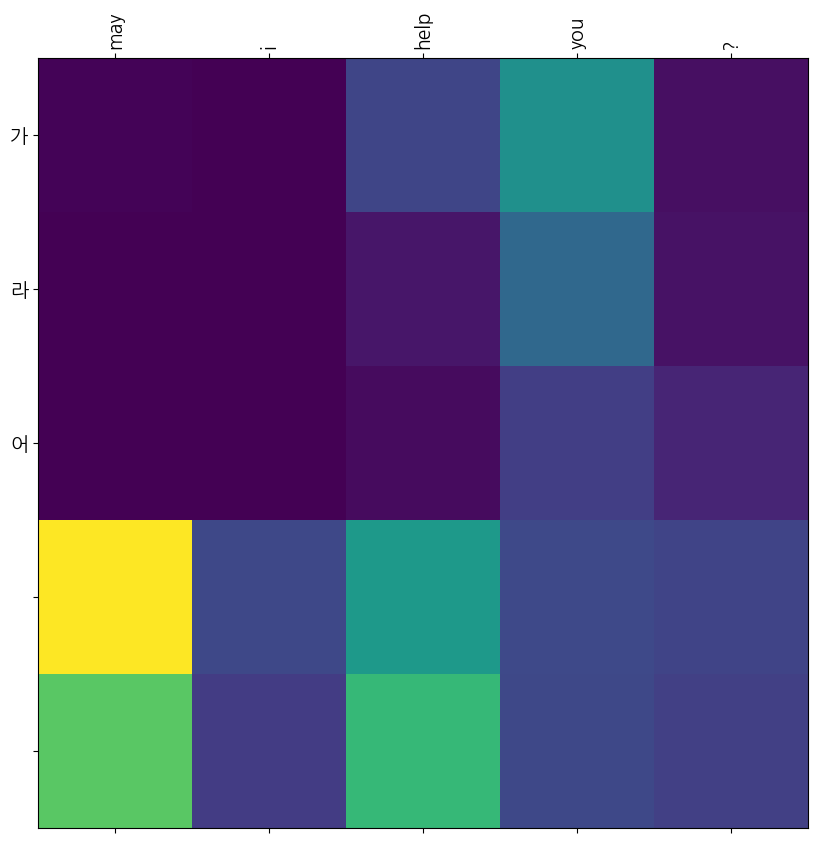

In [134]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=40)

Input: i'm a cat
Predicted translation: 장라야  


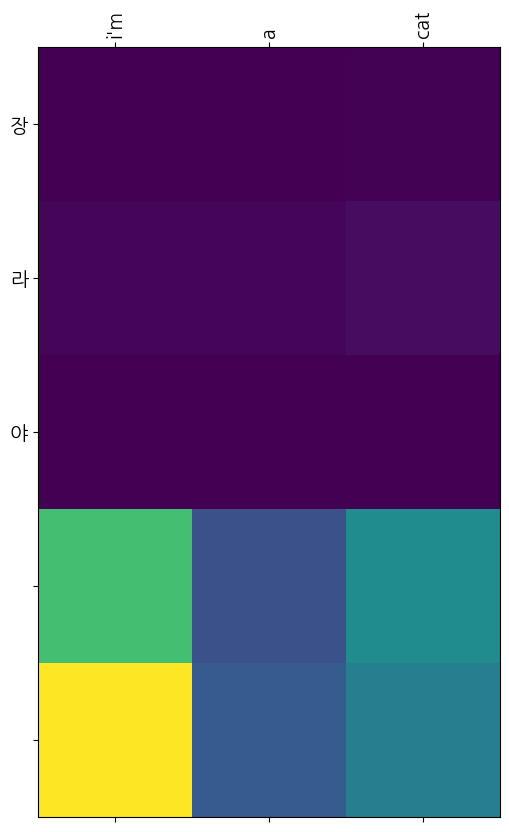

In [135]:
translate("I'm a cat", model, encoder_tokenizer, decoder_tokenizer, max_len=40)

Input: i started a new blog
Predicted translation: 는        어 .


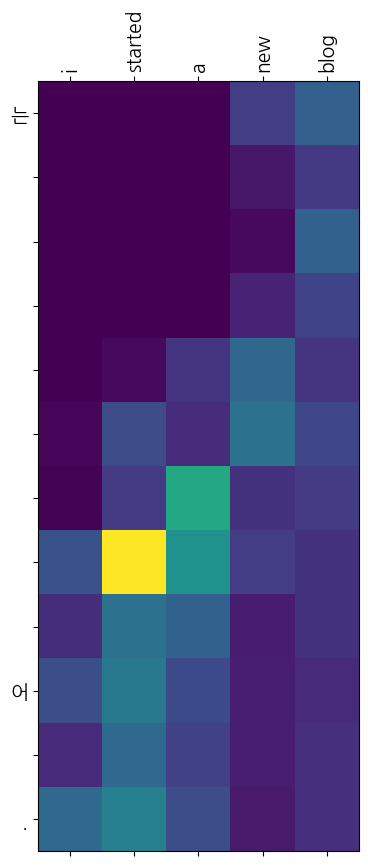

In [136]:
# 실행 예제
translate("i started a new blog", model, encoder_tokenizer, decoder_tokenizer, max_len=40)

In [138]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=30):
    model.eval()

    sentence = preprocess_sentence(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    result = [decoder_tokenizer.decode([token.item()]) for token in outputs.argmax(2).squeeze(1)]

    if "<end>" in result:
        result = result[:result.index("<end>")]

    return result, sentence, attentions.squeeze(1).cpu().numpy()

In [139]:
def plot_attention(attention, sentence, predicted_sentence):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    plt.show()

In [140]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=40):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

Input: the most powerful man all over the world .
Predicted translation: ['의', '', '가', '', '를', '', '', '다', '다', '']


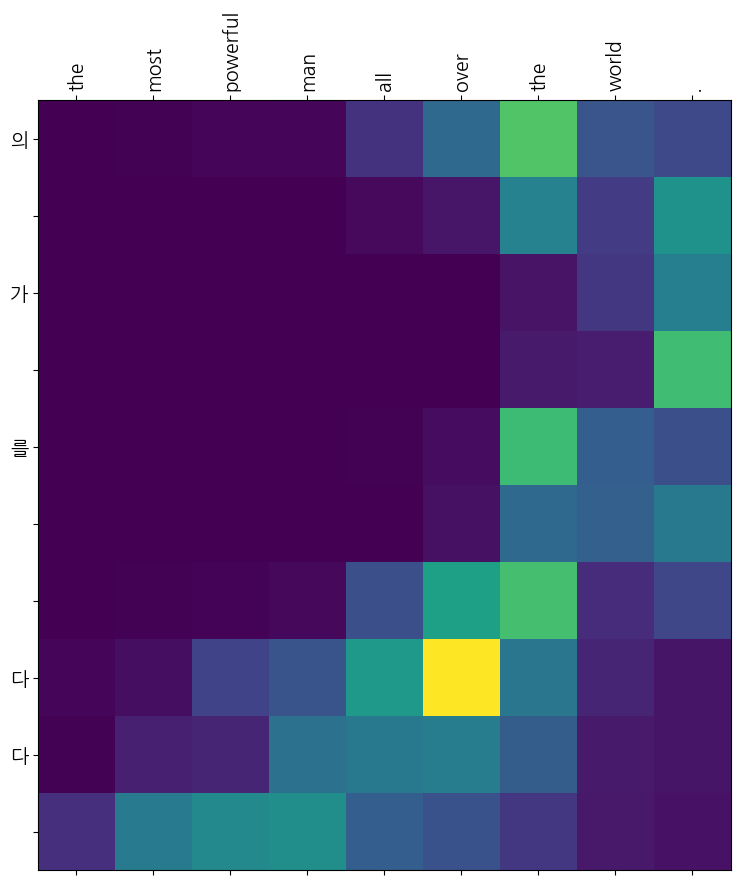

In [141]:
translate("The most powerful man all over the world.", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: may i help you ?
Predicted translation: ['가', '라', '어', '', '', '도', '.', '']


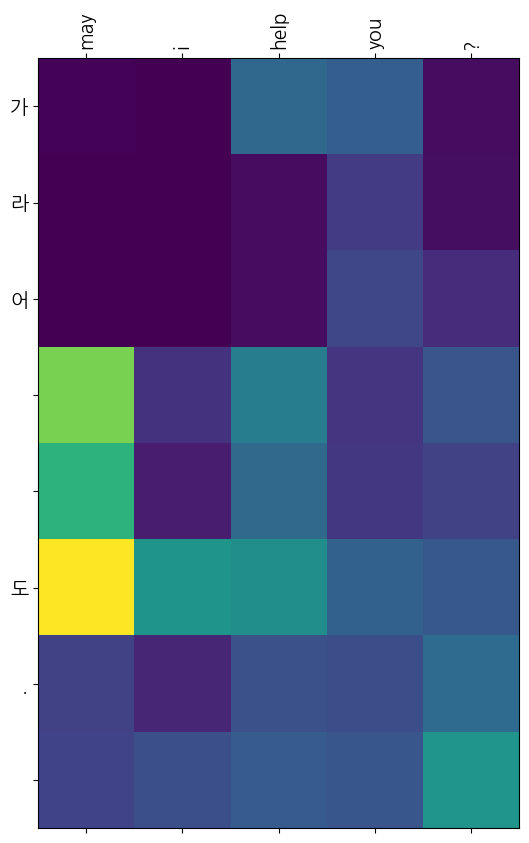

In [142]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

Input: can i have some coffee ?
Predicted translation: ['를', '', '', '도', '수', '', '도', '', '']


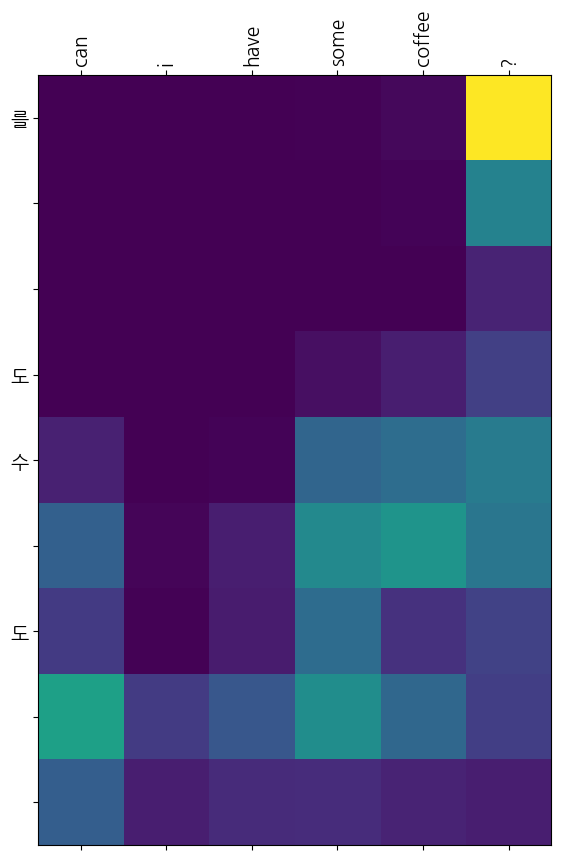

In [143]:
# 실행 예제
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=30)

In [144]:
for src, trg_input, trg_label in train_loader:
    print("trg_input[0]:", trg_input[0].tolist())
    print("trg_label[0]:", trg_label[0].tolist())
    break


trg_input[0]: [1, 11, 7, 4, 2150, 197, 814, 773, 1668, 34, 1382, 24, 1094, 1049, 6, 285, 612, 72, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
trg_label[0]: [11, 7, 4, 2150, 197, 814, 773, 1668, 34, 1382, 24, 1094, 1049, 6, 285, 612, 72, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
